## **`pycoco`** Demo
___

This notebook will go through adding a SN to the CoCo template framework.

In [1]:
# %matplotlib inline
%matplotlib notebook

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3
        
from matplotlib import pyplot as plt
from matplotlib import rc
rc('text', usetex=True)

import os
import json
import copy
import numpy as np
from astropy.table import Table, Column
from collections import OrderedDict

import pycoco as pcc
plt.close("all")

## Download SN
---
The example that I will go through is probably the simplest one - from a JSON that I have downloaded from http://sne.space contaning the information for SN2015U.

In [2]:
data_dir = "/Users/berto/data/CoreCollapse/SNe/" ## Change this to the directory location of the json
# out_data_dir = "/Users/berto/data/CoreCollapse/data/"
out_data_dir = pcc.defaults._default_data_dir_path

snname = "SN2015U"
path = os.path.join(data_dir, "SN2015U.json")

sndict = json.load(open(path, 'r'))[snname]

The `json` file contains quite a bit of information

In [3]:
sndict.keys()

dict_keys(['schema', 'name', 'sources', 'alias', 'claimedtype', 'comovingdist', 'dec', 'discoverdate', 'discoverer', 'ebv', 'host', 'hostdec', 'hostoffsetang', 'hostoffsetdist', 'hostra', 'hostvelocity', 'lumdist', 'maxabsmag', 'maxappmag', 'maxband', 'maxdate', 'maxvisualabsmag', 'maxvisualappmag', 'maxvisualband', 'maxvisualdate', 'ra', 'redshift', 'velocity', 'photometry', 'spectra'])

In [4]:
sndict["redshift"][0]["value"]

'0.01379'

## Spectra
----
How many Spectra do we have?

In [5]:
len(sndict["spectra"])

21

In [6]:
S1 = sndict["spectra"][0]

In [7]:
S1.keys()

dict_keys(['time', 'filename', 'instrument', 'observer', 'reducer', 'snr', 'u_errors', 'u_fluxes', 'u_time', 'u_wavelengths', 'data', 'source'])

In [8]:
w = np.array(S1["data"], dtype=np.float64).T[0]
f = np.array(S1["data"], dtype=np.float64).T[1]

In [9]:
f

array([ 0.17578192,  0.24098685,  0.15754801, ...,  0.15758722,
        0.14430489,  0.1320765 ])

In [10]:
from astropy.table import Table, Column, Row
import astropy.units as u

In [11]:
wavelength = Column(w, name = ("wavelength"), unit=u.Angstrom)
flux = Column(f, name = ("flux"), unit=u.cgs.erg / u.si.cm ** 2 / u.si.s / u.angstrom)

In [12]:
Table([wavelength, flux])

wavelength,flux
Angstrom,erg / (Angstrom cm2 s)
float64,float64
3440.0,0.17578192
3442.0,0.24098685
3444.0,0.15754801
3446.0,0.1271165
3448.0,0.16798687
3450.0,0.15301467
3452.0,0.11438128
3454.0,0.14230451


In [13]:
spec_dict_list = sndict["spectra"]
for s in spec_dict_list:
    print(s["time"], s["filename"])

57068.3 psn0728+3349-20150215.256-ui.flm
57068.3 psn0728+3349.gal-20150215.256-ui.flm
57070.0 PSNJ07285387p3349106_20150217_Ekar182_AFOSC_cal.ascii
57070.0 SN2015U_2015-02-17_20:01:56_Asiago.ascii
57071.0 PSNJ07285387p3349106_20150218_Ekar182_AFOSC_cal.ascii
57071.2 psn0728+3349-20150218.211-ir.flm
57071.2 psn0728+3349.gal-20150218.211-ir.flm
57072.0 PSNJ07285387p3349106_20150219_Ekar182_AFOSC_cal.ascii
57074.2 psn0728+3349-20150221.207-ui.flm
57074.2 psn0728+3349.gal-20150221.207-ui.flm
57074.2 psn0728+3349.sn+gal-20150221.207-ui.flm
57075.0 PSNJ07285387p3349106_20150222_NOT_ALFOSC_cal.ascii
57076.0 PSNJ07285387p3349106_20150223_TNG_LRS_cal.ascii
57077.2 psn0728+3349-20150224.224-ui.flm
57077.4 psn0728+3349-20150224.414-uh.flm
57078.0 PSNJ07285387p3349106_20150225_TNG_LRS_cal.ascii
57078.2 psn0728+3349-20150225.171-ui.flm
57080.3 psn0728+3349-20150227.34.deimos.flm
57081.0 PSNJ07285387p3349106_20150228_TNG_LRS_cal.ascii
57084.0 PSNJ07285387p3349106_20150303_NOT_ALFOSC_cal.ascii
57092.

## Duplicates
---

There are a number of duplicates, some with extra calibration steps etc.

In [14]:
len(np.unique([s["time"] for s in spec_dict_list])) == len(spec_dict_list)

False

Taking a look at the filenames, I'll skip over the following (one of the duplicate MJDs seems to be a genuine concurrent observation)

In [15]:
skip_spec = ["psn0728+3349.gal-20150215.256-ui.flm",
             "psn0728+3349.gal-20150218.211-ir.flm",
             "psn0728+3349.gal-20150221.207-ui.flm",
             "psn0728+3349.sn+gal-20150221.207-ui.flm"]

In [16]:
out_dict = OrderedDict()

uncombined=np.array([])
spec_filenames = [spec["filename"] for spec in sndict["spectra"]]
# print(spec_filenames)
spec_dir = os.path.join(out_data_dir, "spec/SN2015U/")

# if not os.path.isdir(os.path.abspath(os.path.join(spec_dir, os.path.pardir))):
#     os.mkdir(os.path.abspath(os.path.join(spec_dir, os.path.pardir)))
if not os.path.isdir(spec_dir):
    os.makedirs(spec_dir)
    
good_spec_filenames = [spec for spec in spec_filenames if spec not in skip_spec]

print("there are ", len(good_spec_filenames), "spectra")

there are  17 spectra


## Moving to **`pycoco`**
___
Now we have identified the good spectra, we can load them into `pycoco` format

In [17]:
plot_all = True
save = True
# for spec_file in np.array(spec_filenames):
for spec_file in np.array(good_spec_filenames):
    print(spec_file)
    
    w = np.where(np.array(spec_filenames) == spec_file)[0][0]
    print(w)
    
    wavl = np.array(spec_dict_list[w]["data"], dtype=np.float64).T[0]
    flux = np.array(spec_dict_list[w]["data"], dtype=np.float64).T[1]

    wavelength = Column(wavl, name = ("wavelength"), unit=u.Angstrom)
    flux = Column(flux, name = ("flux"), unit=u.cgs.erg / u.si.cm ** 2 / u.si.s / u.angstrom)

    spec_table = Table([wavelength, flux])

    s = pcc.classes.SpectrumClass()

    s.load_table(spec_table, path="")
    print(os.path.join(spec_dir, spec_file))
    if save:
        s.save(spec_file, path=spec_dir, )
    out_dict = OrderedDict()
    out_dict["filename"] = os.path.join(spec_dir, spec_file)
    out_dict["time"] = np.float64(spec_dict_list[w]["time"])
    out_dict["redshift"] = np.float64(sndict["redshift"][0]["value"])
    print("redshift ", out_dict["redshift"])
    out_dict["snname"] = snname
    print(spec_dict_list[w]["time"])
    uncombined = np.append(uncombined, out_dict)
    
    if plot_all:
        s.plot()

psn0728+3349-20150215.256-ui.flm
0
/Users/berto/Code/CoCo/data/spec/SN2015U/psn0728+3349-20150215.256-ui.flm
has data
redshift  0.01379
57068.3


/Users/berto/Code/verbose-enigma/pycoco/classes.py:496: UserWarning: Found existing file matching /Users/berto/Code/CoCo/data/spec/SN2015U/psn0728+3349-20150215.256-ui.flm. Run with squash = True to overwrite
  filename) + ". Run with squash = True to overwrite")


<IPython.core.display.Javascript object>

PSNJ07285387p3349106_20150217_Ekar182_AFOSC_cal.ascii
2
/Users/berto/Code/CoCo/data/spec/SN2015U/PSNJ07285387p3349106_20150217_Ekar182_AFOSC_cal.ascii
has data
redshift  0.01379
57070.0


/Users/berto/Code/verbose-enigma/pycoco/classes.py:496: UserWarning: Found existing file matching /Users/berto/Code/CoCo/data/spec/SN2015U/PSNJ07285387p3349106_20150217_Ekar182_AFOSC_cal.ascii. Run with squash = True to overwrite
  filename) + ". Run with squash = True to overwrite")


<IPython.core.display.Javascript object>

SN2015U_2015-02-17_20:01:56_Asiago.ascii
3
/Users/berto/Code/CoCo/data/spec/SN2015U/SN2015U_2015-02-17_20:01:56_Asiago.ascii
has data
redshift  0.01379
57070.0


/Users/berto/Code/verbose-enigma/pycoco/classes.py:496: UserWarning: Found existing file matching /Users/berto/Code/CoCo/data/spec/SN2015U/SN2015U_2015-02-17_20:01:56_Asiago.ascii. Run with squash = True to overwrite
  filename) + ". Run with squash = True to overwrite")


<IPython.core.display.Javascript object>

PSNJ07285387p3349106_20150218_Ekar182_AFOSC_cal.ascii
4
/Users/berto/Code/CoCo/data/spec/SN2015U/PSNJ07285387p3349106_20150218_Ekar182_AFOSC_cal.ascii
has data
redshift  0.01379
57071.0


/Users/berto/Code/verbose-enigma/pycoco/classes.py:496: UserWarning: Found existing file matching /Users/berto/Code/CoCo/data/spec/SN2015U/PSNJ07285387p3349106_20150218_Ekar182_AFOSC_cal.ascii. Run with squash = True to overwrite
  filename) + ". Run with squash = True to overwrite")


<IPython.core.display.Javascript object>

psn0728+3349-20150218.211-ir.flm
5
/Users/berto/Code/CoCo/data/spec/SN2015U/psn0728+3349-20150218.211-ir.flm
has data
redshift  0.01379
57071.2


/Users/berto/Code/verbose-enigma/pycoco/classes.py:496: UserWarning: Found existing file matching /Users/berto/Code/CoCo/data/spec/SN2015U/psn0728+3349-20150218.211-ir.flm. Run with squash = True to overwrite
  filename) + ". Run with squash = True to overwrite")


<IPython.core.display.Javascript object>

PSNJ07285387p3349106_20150219_Ekar182_AFOSC_cal.ascii
7
/Users/berto/Code/CoCo/data/spec/SN2015U/PSNJ07285387p3349106_20150219_Ekar182_AFOSC_cal.ascii
has data
redshift  0.01379
57072.0


/Users/berto/Code/verbose-enigma/pycoco/classes.py:496: UserWarning: Found existing file matching /Users/berto/Code/CoCo/data/spec/SN2015U/PSNJ07285387p3349106_20150219_Ekar182_AFOSC_cal.ascii. Run with squash = True to overwrite
  filename) + ". Run with squash = True to overwrite")


<IPython.core.display.Javascript object>

psn0728+3349-20150221.207-ui.flm
8
/Users/berto/Code/CoCo/data/spec/SN2015U/psn0728+3349-20150221.207-ui.flm
has data
redshift  0.01379
57074.2


/Users/berto/Code/verbose-enigma/pycoco/classes.py:496: UserWarning: Found existing file matching /Users/berto/Code/CoCo/data/spec/SN2015U/psn0728+3349-20150221.207-ui.flm. Run with squash = True to overwrite
  filename) + ". Run with squash = True to overwrite")


<IPython.core.display.Javascript object>

PSNJ07285387p3349106_20150222_NOT_ALFOSC_cal.ascii
11
/Users/berto/Code/CoCo/data/spec/SN2015U/PSNJ07285387p3349106_20150222_NOT_ALFOSC_cal.ascii
has data
redshift  0.01379
57075.0


/Users/berto/Code/verbose-enigma/pycoco/classes.py:496: UserWarning: Found existing file matching /Users/berto/Code/CoCo/data/spec/SN2015U/PSNJ07285387p3349106_20150222_NOT_ALFOSC_cal.ascii. Run with squash = True to overwrite
  filename) + ". Run with squash = True to overwrite")


<IPython.core.display.Javascript object>

PSNJ07285387p3349106_20150223_TNG_LRS_cal.ascii
12
/Users/berto/Code/CoCo/data/spec/SN2015U/PSNJ07285387p3349106_20150223_TNG_LRS_cal.ascii
has data
redshift  0.01379
57076.0


/Users/berto/Code/verbose-enigma/pycoco/classes.py:496: UserWarning: Found existing file matching /Users/berto/Code/CoCo/data/spec/SN2015U/PSNJ07285387p3349106_20150223_TNG_LRS_cal.ascii. Run with squash = True to overwrite
  filename) + ". Run with squash = True to overwrite")


<IPython.core.display.Javascript object>

psn0728+3349-20150224.224-ui.flm
13
/Users/berto/Code/CoCo/data/spec/SN2015U/psn0728+3349-20150224.224-ui.flm
has data
redshift  0.01379
57077.2


/Users/berto/Code/verbose-enigma/pycoco/classes.py:496: UserWarning: Found existing file matching /Users/berto/Code/CoCo/data/spec/SN2015U/psn0728+3349-20150224.224-ui.flm. Run with squash = True to overwrite
  filename) + ". Run with squash = True to overwrite")


<IPython.core.display.Javascript object>

psn0728+3349-20150224.414-uh.flm
14
/Users/berto/Code/CoCo/data/spec/SN2015U/psn0728+3349-20150224.414-uh.flm
has data
redshift  0.01379
57077.4


/Users/berto/Code/verbose-enigma/pycoco/classes.py:496: UserWarning: Found existing file matching /Users/berto/Code/CoCo/data/spec/SN2015U/psn0728+3349-20150224.414-uh.flm. Run with squash = True to overwrite
  filename) + ". Run with squash = True to overwrite")


<IPython.core.display.Javascript object>

PSNJ07285387p3349106_20150225_TNG_LRS_cal.ascii
15
/Users/berto/Code/CoCo/data/spec/SN2015U/PSNJ07285387p3349106_20150225_TNG_LRS_cal.ascii
has data
redshift  0.01379
57078.0


/Users/berto/Code/verbose-enigma/pycoco/classes.py:496: UserWarning: Found existing file matching /Users/berto/Code/CoCo/data/spec/SN2015U/PSNJ07285387p3349106_20150225_TNG_LRS_cal.ascii. Run with squash = True to overwrite
  filename) + ". Run with squash = True to overwrite")


<IPython.core.display.Javascript object>

psn0728+3349-20150225.171-ui.flm
16
/Users/berto/Code/CoCo/data/spec/SN2015U/psn0728+3349-20150225.171-ui.flm
has data
redshift  0.01379
57078.2


/Users/berto/Code/verbose-enigma/pycoco/classes.py:496: UserWarning: Found existing file matching /Users/berto/Code/CoCo/data/spec/SN2015U/psn0728+3349-20150225.171-ui.flm. Run with squash = True to overwrite
  filename) + ". Run with squash = True to overwrite")


<IPython.core.display.Javascript object>

psn0728+3349-20150227.34.deimos.flm
17
/Users/berto/Code/CoCo/data/spec/SN2015U/psn0728+3349-20150227.34.deimos.flm
has data
redshift  0.01379
57080.3


/Users/berto/Code/verbose-enigma/pycoco/classes.py:496: UserWarning: Found existing file matching /Users/berto/Code/CoCo/data/spec/SN2015U/psn0728+3349-20150227.34.deimos.flm. Run with squash = True to overwrite
  filename) + ". Run with squash = True to overwrite")


<IPython.core.display.Javascript object>

PSNJ07285387p3349106_20150228_TNG_LRS_cal.ascii
18
/Users/berto/Code/CoCo/data/spec/SN2015U/PSNJ07285387p3349106_20150228_TNG_LRS_cal.ascii
has data
redshift  0.01379
57081.0


/Users/berto/Code/verbose-enigma/pycoco/classes.py:496: UserWarning: Found existing file matching /Users/berto/Code/CoCo/data/spec/SN2015U/PSNJ07285387p3349106_20150228_TNG_LRS_cal.ascii. Run with squash = True to overwrite
  filename) + ". Run with squash = True to overwrite")


<IPython.core.display.Javascript object>

PSNJ07285387p3349106_20150303_NOT_ALFOSC_cal.ascii
19
/Users/berto/Code/CoCo/data/spec/SN2015U/PSNJ07285387p3349106_20150303_NOT_ALFOSC_cal.ascii
has data
redshift  0.01379
57084.0


/Users/berto/Code/verbose-enigma/pycoco/classes.py:496: UserWarning: Found existing file matching /Users/berto/Code/CoCo/data/spec/SN2015U/PSNJ07285387p3349106_20150303_NOT_ALFOSC_cal.ascii. Run with squash = True to overwrite
  filename) + ". Run with squash = True to overwrite")


<IPython.core.display.Javascript object>

PSNJ07285387p3349106_20150311_NOT_ALFOSC_cal.ascii
20
/Users/berto/Code/CoCo/data/spec/SN2015U/PSNJ07285387p3349106_20150311_NOT_ALFOSC_cal.ascii
has data
redshift  0.01379
57092.0


/Users/berto/Code/verbose-enigma/pycoco/classes.py:496: UserWarning: Found existing file matching /Users/berto/Code/CoCo/data/spec/SN2015U/PSNJ07285387p3349106_20150311_NOT_ALFOSC_cal.ascii. Run with squash = True to overwrite
  filename) + ". Run with squash = True to overwrite")


<IPython.core.display.Javascript object>

We now have an array of Dictionaries containing the info for the list file

In [18]:
out_array = uncombined

out_array

array([ OrderedDict([('filename', '/Users/berto/Code/CoCo/data/spec/SN2015U/psn0728+3349-20150215.256-ui.flm'), ('time', 57068.300000000003), ('redshift', 0.01379), ('snname', 'SN2015U')]),
       OrderedDict([('filename', '/Users/berto/Code/CoCo/data/spec/SN2015U/PSNJ07285387p3349106_20150217_Ekar182_AFOSC_cal.ascii'), ('time', 57070.0), ('redshift', 0.01379), ('snname', 'SN2015U')]),
       OrderedDict([('filename', '/Users/berto/Code/CoCo/data/spec/SN2015U/SN2015U_2015-02-17_20:01:56_Asiago.ascii'), ('time', 57070.0), ('redshift', 0.01379), ('snname', 'SN2015U')]),
       OrderedDict([('filename', '/Users/berto/Code/CoCo/data/spec/SN2015U/PSNJ07285387p3349106_20150218_Ekar182_AFOSC_cal.ascii'), ('time', 57071.0), ('redshift', 0.01379), ('snname', 'SN2015U')]),
       OrderedDict([('filename', '/Users/berto/Code/CoCo/data/spec/SN2015U/psn0728+3349-20150218.211-ir.flm'), ('time', 57071.199999999997), ('redshift', 0.01379), ('snname', 'SN2015U')]),
       OrderedDict([('filename', '/Us

In [19]:
keys = ["filename",
        "snname",
        "time",
        "redshift"]
columns = []
for key in keys:
    columns.append([i[key] for i in out_array])

Change 'time' to 'MJD' as is our convention, we can take a look at our listfile by adding all of the columns together

In [20]:
keys[2] = "MJD"
list_table = Table(columns, names = keys)

list_table.add_index("MJD")
list_table.sort()

list_table

filename,snname,MJD,redshift
str94,str7,float64,float64
/Users/berto/Code/CoCo/data/spec/SN2015U/psn0728+3349-20150215.256-ui.flm,SN2015U,57068.3,0.01379
/Users/berto/Code/CoCo/data/spec/SN2015U/PSNJ07285387p3349106_20150217_Ekar182_AFOSC_cal.ascii,SN2015U,57070.0,0.01379
/Users/berto/Code/CoCo/data/spec/SN2015U/SN2015U_2015-02-17_20:01:56_Asiago.ascii,SN2015U,57070.0,0.01379
/Users/berto/Code/CoCo/data/spec/SN2015U/PSNJ07285387p3349106_20150218_Ekar182_AFOSC_cal.ascii,SN2015U,57071.0,0.01379
/Users/berto/Code/CoCo/data/spec/SN2015U/psn0728+3349-20150218.211-ir.flm,SN2015U,57071.2,0.01379
/Users/berto/Code/CoCo/data/spec/SN2015U/PSNJ07285387p3349106_20150219_Ekar182_AFOSC_cal.ascii,SN2015U,57072.0,0.01379
/Users/berto/Code/CoCo/data/spec/SN2015U/psn0728+3349-20150221.207-ui.flm,SN2015U,57074.2,0.01379
/Users/berto/Code/CoCo/data/spec/SN2015U/PSNJ07285387p3349106_20150222_NOT_ALFOSC_cal.ascii,SN2015U,57075.0,0.01379
/Users/berto/Code/CoCo/data/spec/SN2015U/PSNJ07285387p3349106_20150223_TNG_LRS_cal.ascii,SN2015U,57076.0,0.01379


Since we're happy with this (maybe we can do something with the absolute paths?) we can save it.

In [21]:
list_out_path = os.path.join(pcc.defaults._default_list_dir_path, snname+".list")
list_table.write(list_out_path, format="ascii.no_header")

# Photometry
---
We have the spectra in hand, now we can faff about with the phot.

In [22]:
sndict["photometry"]

[{'band': 'clear',
  'e_magnitude': '0.1515',
  'magnitude': '18.0616',
  'source': '1,13',
  'telescope': 'KAIT',
  'time': '57064.24',
  'u_time': 'MJD'},
 {'band': 'clear',
  'e_magnitude': '0.0646',
  'magnitude': '16.8465',
  'source': '1,13',
  'telescope': 'KAIT',
  'time': '57066.22',
  'u_time': 'MJD'},
 {'band': 'B',
  'e_magnitude': '0.1749',
  'magnitude': '17.7117',
  'source': '1,13',
  'telescope': 'KAIT',
  'time': '57067.35',
  'u_time': 'MJD'},
 {'band': 'R',
  'e_magnitude': '0.0592',
  'magnitude': '16.4640',
  'source': '1,13',
  'telescope': 'KAIT',
  'time': '57067.35',
  'u_time': 'MJD'},
 {'band': 'V',
  'e_magnitude': '0.0891',
  'magnitude': '16.9832',
  'source': '1,13',
  'telescope': 'KAIT',
  'time': '57067.35',
  'u_time': 'MJD'},
 {'band': 'clear',
  'e_magnitude': '0.0542',
  'magnitude': '16.5726',
  'source': '1,13',
  'telescope': 'KAIT',
  'time': '57067.35',
  'u_time': 'MJD'},
 {'band': 'I',
  'e_magnitude': '0.0766',
  'magnitude': '16.1834',
  

We can tweak the dicts into a slightly less fiddly structure and load it into a table.

In [23]:
phot_dict_list = sndict["photometry"]
new_phot_dict_list = []
for i in phot_dict_list:
    out_dict = OrderedDict()
    
    out_dict["MJD"] = np.float64(i["time"])
    out_dict["mag"] = np.float64(i["magnitude"])
    out_dict["dmag"] = np.float64(i["e_magnitude"])
    out_dict["filter"] = i["band"]
    
    new_phot_dict_list.append(out_dict)

phot_table=Table(rows=new_phot_dict_list)

phot_table

MJD,dmag,filter,mag
float64,float64,str5,float64
57064.24,0.1515,clear,18.0616
57066.22,0.0646,clear,16.8465
57067.35,0.1749,B,17.7117
57067.35,0.0592,R,16.464
57067.35,0.0891,V,16.9832
57067.35,0.0542,clear,16.5726
57067.36,0.0766,I,16.1834
57068.21,0.1072,B,17.6548
57068.22,0.0561,I,16.2318


### Filters
___

Don't yet know how to deal with "clear" filters so I'll put it to one side (i.e. ditch it). The other filters need to be converted into ones that are in the filter registry. If you've forgotten what is in there:

In [24]:
pcc.utils._get_current_filter_registry()

array(['2MASS_H.dat', '2MASS_J.dat', '2MASS_Ks.dat', 'all_filters.list',
       'B.dat', 'BessellB.dat', 'BessellI.dat', 'BessellR.dat',
       'BessellU.dat', 'BessellV.dat', 'Bol.dat', 'DES_g.dat', 'DES_i.dat',
       'DES_r.dat', 'DES_y.dat', 'DES_z.dat', 'DESg.dat', 'DESi.dat',
       'DESr.dat', 'DESu.dat', 'DESy.dat', 'DESz.dat', 'F2_Y.dat', 'g.dat',
       'gaussian_6000_500.dat', 'gsSAGEMrf4.dat', 'H.dat',
       'hardware_g.dat', 'hardware_i.dat', 'hardware_r.dat',
       'hardware_u.dat', 'hardware_y.dat', 'hardware_z.dat', 'hawki_Y.dat',
       'HST_F755.abs', 'HST_F775W.dat', 'HST_F850.dat', "i'.dat", 'i.dat',
       'isSAGEMrf4.dat', 'J.dat', 'K.dat', 'LSQ_gr.dat', 'LSST_g.dat',
       'LSST_i.dat', 'LSST_r.dat', 'LSST_u.dat', 'LSST_y.dat',
       'LSST_z.dat', 'PS1_g.dat', 'PS1_i.dat', 'PS1_r.dat', 'PS1_y.dat',
       'PS1_z.dat', 'PS1g.dat', 'PS1i.dat', 'PS1r.dat', 'PS1y.dat',
       'PS1z.dat', 'PTF48_g.dat', 'PTF48_R.dat', "r'.dat", 'r.dat',
       'rsSAGEMrf4.dat', 'S

In [25]:
w = np.where(phot_table["filter"] != "clear")
# print(w)

phot_table_filtered = phot_table[w]

## Converting to Flux
___

All of the reported phot is in Mags. We need to work out Zeropoints and convert to flux.

In [26]:
# pcc.kcorr.calc_AB_zp?
filt_dict = OrderedDict()

for filter_name in np.unique(phot_table_filtered["filter"]):
#     filter_name = "Bessell"+filter_name
#     filter_dir_path = os.path.join(pcc.defaults._default_filter_dir_path, "Bessell"+filter_name+".dat")
    print(filter_name)
    filter_object = pcc.classes.FilterClass()
    filter_object.load(path=os.path.join(pcc.defaults._default_filter_dir_path, "Bessell"+filter_name+".dat"), fmt="ascii",
                      name="Bessell"+filter_name)
    filter_object.calculate_AB_zp()
    filt_dict["Bessell"+filter_name]=filter_object

B
I
R
V


In [27]:
phot_table_filtered["filter"] = Column(list(map(lambda x: "Bessell"+x, phot_table_filtered["filter"])))

phot_table_filtered

MJD,dmag,filter,mag
float64,float64,str8,float64
57067.35,0.1749,BessellB,17.7117
57067.35,0.0592,BessellR,16.464
57067.35,0.0891,BessellV,16.9832
57067.36,0.0766,BessellI,16.1834
57068.21,0.1072,BessellB,17.6548
57068.22,0.0561,BessellI,16.2318
57068.22,0.0277,BessellR,16.4146
57068.22,0.0476,BessellV,16.8599
57070.19,0.0874,BessellB,17.6547


In [28]:
# filt_dict["BessellB"].zp_AB
phot_table_filtered["zp_AB"] = Column(list(map(lambda x: filt_dict[x].zp_AB, phot_table_filtered["filter"])),
                                      name="zp_AB")

In [29]:
phot_table_filtered["flux"] = Column(np.power(10.0, -(phot_table_filtered["mag"]+phot_table_filtered["zp_AB"])/2.5),
                                      name="flux", unit=u.cgs.erg / u.si.angstrom / u.si.cm ** 2 / u.si.s)
phot_table_filtered["flux_err"] = Column(phot_table_filtered["flux"] / (1.086 * phot_table_filtered["mag"]/phot_table_filtered["dmag"]),
                                        name="flux_error", unit=u.cgs.erg / u.si.angstrom / u.si.cm ** 2 / u.si.s)

phot_table_filtered

MJD,dmag,filter,mag,zp_AB,flux,flux_err
,,,,,erg / (Angstrom cm2 s),erg / (Angstrom cm2 s)
float64,float64,str8,float64,float64,float64,float64
57067.35,0.1749,BessellB,17.7117,20.6107448455,4.68837198092e-16,4.26306346876e-18
57067.35,0.0592,BessellR,16.464,21.4714328359,6.69617608692e-16,2.21709033978e-18
57067.35,0.0891,BessellV,16.9832,21.1007523635,5.84008347334e-16,2.82128792012e-18
57067.36,0.0766,BessellI,16.1834,21.9208217455,5.73206757725e-16,2.49827635499e-18
57068.21,0.1072,BessellB,17.6548,20.6107448455,4.9406269362e-16,2.76238508105e-18
57068.22,0.0561,BessellI,16.2318,21.9208217455,5.48215489109e-16,1.74468752157e-18
57068.22,0.0277,BessellR,16.4146,21.4714328359,7.00788337365e-16,1.08894640471e-18
57068.22,0.0476,BessellV,16.8599,21.1007523635,6.54242954735e-16,1.70083109715e-18


In [30]:
out_phot = phot_table_filtered[("MJD", "flux", "flux_err", "filter")]
out_phot

MJD,flux,flux_err,filter
,erg / (Angstrom cm2 s),erg / (Angstrom cm2 s),
float64,float64,float64,str8
57067.35,4.68837198092e-16,4.26306346876e-18,BessellB
57067.35,6.69617608692e-16,2.21709033978e-18,BessellR
57067.35,5.84008347334e-16,2.82128792012e-18,BessellV
57067.36,5.73206757725e-16,2.49827635499e-18,BessellI
57068.21,4.9406269362e-16,2.76238508105e-18,BessellB
57068.22,5.48215489109e-16,1.74468752157e-18,BessellI
57068.22,7.00788337365e-16,1.08894640471e-18,BessellR
57068.22,6.54242954735e-16,1.70083109715e-18,BessellV


In [31]:
phot_dir = os.path.join(out_data_dir, "lc/")

if not os.path.isdir(phot_dir):
    os.makedirs(phot_dir)
    
phot_filename = "SN2015U.dat"
phot_outpath = os.path.join(phot_dir, phot_filename)
out_phot.write(phot_outpath, format = "ascii.fast_commented_header")


## The Infofile
----
This is needed for the simulation and a few other bits (_citation needed_)

In [32]:
info = pcc.classes.InfoClass()
info.load()

In [33]:
info._data

snname,z_obs,mu,RA,Dec,Type,z_distmod,SkyCoords
,,,,,,,"deg,deg"
str9,float64,float64,str13,str13,str3,float64,object
SN1993J,-0.0001,27.82,09:55:24.7747,+69:01:13.702,IIb,0.000846738572567,"148.85322791666664,69.02047277777778"
SN1994I,0.0015,29.5,13:29:54.072,+47:11:30.50,Ic,0.00183405936246,"202.47529999999995,47.191805555555554"
SN1996cb,0.0024,30.69,11:03:41.98,+28:54:13.7,IIb,0.00316927429659,"165.92491666666666,28.903805555555554"
SN1998bw,0.0085,32.69,19:35:03.17,-52:50:46.1,Ic,0.0079313906637,"293.76320833333324,-52.846138888888895"
SN1999dn,0.0093,32.44,23:36:14.70,+02:09:08.8,Ib,0.00707356943468,"354.06125,2.1524444444444444"
SN2002ap,0.0022,29.76,01:36:23.85,+15:45:13.2,Ic,0.00206697015015,"24.099375,15.753666666666666"
SN2003jd,0.0188,34.33,23:21:03.38,-04:53:45.5,Ic,0.0167645346609,"350.2640833333333,-4.8959722222222215"
SN2004aw,0.0159,34.48,11:57:50.24,+25:15:55.1,Ic,0.0179472672389,"179.45933333333332,25.265305555555557"


In [34]:
small_table = info._data[("snname", "z_obs", "mu", "RA", "Dec", "Type", "z_distmod")]

In [35]:
small_table

snname,z_obs,mu,RA,Dec,Type,z_distmod
str9,float64,float64,str13,str13,str3,float64
SN1993J,-0.0001,27.82,09:55:24.7747,+69:01:13.702,IIb,0.000846738572567
SN1994I,0.0015,29.5,13:29:54.072,+47:11:30.50,Ic,0.00183405936246
SN1996cb,0.0024,30.69,11:03:41.98,+28:54:13.7,IIb,0.00316927429659
SN1998bw,0.0085,32.69,19:35:03.17,-52:50:46.1,Ic,0.0079313906637
SN1999dn,0.0093,32.44,23:36:14.70,+02:09:08.8,Ib,0.00707356943468
SN2002ap,0.0022,29.76,01:36:23.85,+15:45:13.2,Ic,0.00206697015015
SN2003jd,0.0188,34.33,23:21:03.38,-04:53:45.5,Ic,0.0167645346609
SN2004aw,0.0159,34.48,11:57:50.24,+25:15:55.1,Ic,0.0179472672389
SN2005bf,0.0189,34.73,10:23:56.99,-03:11:29.3,Ib,0.020104028552


In [36]:
sndict.keys()

dict_keys(['schema', 'name', 'sources', 'alias', 'claimedtype', 'comovingdist', 'dec', 'discoverdate', 'discoverer', 'ebv', 'host', 'hostdec', 'hostoffsetang', 'hostoffsetdist', 'hostra', 'hostvelocity', 'lumdist', 'maxabsmag', 'maxappmag', 'maxband', 'maxdate', 'maxvisualabsmag', 'maxvisualappmag', 'maxvisualband', 'maxvisualdate', 'ra', 'redshift', 'velocity', 'photometry', 'spectra'])

In [37]:
sndict["lumdist"]

[{'derived': True,
  'source': '2,4,9,10,12,14,16',
  'u_value': 'Mpc',
  'value': '61.673'}]

In [38]:
from astropy.cosmology import LambdaCDM
from astropy.coordinates import Distance

mu = 33.92 ## from NED -- https://ned.ipac.caltech.edu/cgi-bin/objsearch?objname=NGC+2388&extend=no&hconst=70.5&omegam=0.27&omegav=0.73&corr_z=1&out_csys=Equatorial&out_equinox=J2000.0&obj_sort=RA+or+Longitude&of=pre_text&zv_breaker=30000.0&list_limit=5&img_stamp=YES#NR_Distances_0
d = Distance(distmod=mu)

z_distmod = d.z

In [39]:
(snname, sndict["redshift"][0]["value"], mu, sndict["ra"][0]["value"], sndict["dec"][0]["value"], sndict["claimedtype"][0]["value"].replace("/", ""), z_distmod)

('SN2015U',
 '0.01379',
 33.92,
 '07:28:53.87',
 '+33:49:10.6',
 'Ibn',
 0.013910509586282496)

In [40]:
small_table.add_row((snname, sndict["redshift"][0]["value"], mu, sndict["ra"][0]["value"], sndict["dec"][0]["value"], sndict["claimedtype"][0]["value"].replace("/", ""), z_distmod))

In [41]:
small_table

snname,z_obs,mu,RA,Dec,Type,z_distmod
str9,float64,float64,str13,str13,str3,float64
SN1993J,-0.0001,27.82,09:55:24.7747,+69:01:13.702,IIb,0.000846738572567
SN1994I,0.0015,29.5,13:29:54.072,+47:11:30.50,Ic,0.00183405936246
SN1996cb,0.0024,30.69,11:03:41.98,+28:54:13.7,IIb,0.00316927429659
SN1998bw,0.0085,32.69,19:35:03.17,-52:50:46.1,Ic,0.0079313906637
SN1999dn,0.0093,32.44,23:36:14.70,+02:09:08.8,Ib,0.00707356943468
SN2002ap,0.0022,29.76,01:36:23.85,+15:45:13.2,Ic,0.00206697015015
SN2003jd,0.0188,34.33,23:21:03.38,-04:53:45.5,Ic,0.0167645346609
SN2004aw,0.0159,34.48,11:57:50.24,+25:15:55.1,Ic,0.0179472672389
SN2005bf,0.0189,34.73,10:23:56.99,-03:11:29.3,Ib,0.020104028552


In [42]:
outfile = pcc.defaults._default_info_path.replace(".dat", "_new.dat")
small_table.write(outfile, format="ascii.commented_header")


## Phasefile
___

Similarly, we must add to the phase file.

In [43]:
phasefile_path = os.path.join(pcc.defaults._default_coco_dir_path, "examples/phase.list")
phase_table = pcc.utils.read_phasefile(phasefile_path)
phase_table

snname,z_obs,mu
str9,float64,float64
SN1993J,-0.0001,27.82
SN1994I,0.0015,29.5
SN1996cb,0.0024,30.69
SN1998bw,0.0085,32.69
SN1999dn,0.0093,32.44
SN2002ap,0.0022,29.76
SN2003jd,0.0188,34.33
SN2004aw,0.0159,34.48
SN2005bf,0.0189,34.73


In [44]:
phase_table.add_row((snname, sndict["redshift"][0]["value"], mu))
phase_table

snname,z_obs,mu
str9,float64,float64
SN1993J,-0.0001,27.82
SN1994I,0.0015,29.5
SN1996cb,0.0024,30.69
SN1998bw,0.0085,32.69
SN1999dn,0.0093,32.44
SN2002ap,0.0022,29.76
SN2003jd,0.0188,34.33
SN2004aw,0.0159,34.48
SN2005bf,0.0189,34.73


In [45]:
overwrite=True
phase_table.write(phasefile_path, format="ascii.fast_no_header", overwrite=overwrite)

# **`CoCo`**
___


In [46]:
pcc.coco.test_LCfit("SN2015U")

/Users/berto/Code/CoCo/
Looks like you have done a fit, I found  /Users/berto/Code/CoCo/recon/SN2015U.stat
Looks like you have done a fit, I found  /Users/berto/Code/CoCo/recon/SN2015U.dat


True

In [48]:
# if not pcc.coco.test_LCfit("SN2015U"):
# run_lcfit = True
run_lcfit = False
if run_lcfit:
    pcc.coco.run_LCfit(phot_outpath)

<IPython.core.display.Javascript object>


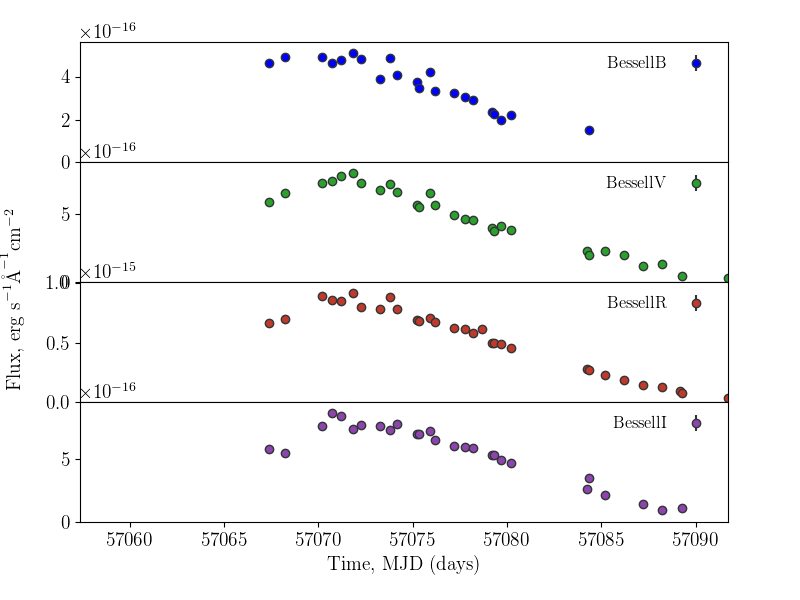

In [49]:
SN = pcc.classes.SNClass(snname)
SN.load_phot()
SN.plot_lc()

<IPython.core.display.Javascript object>


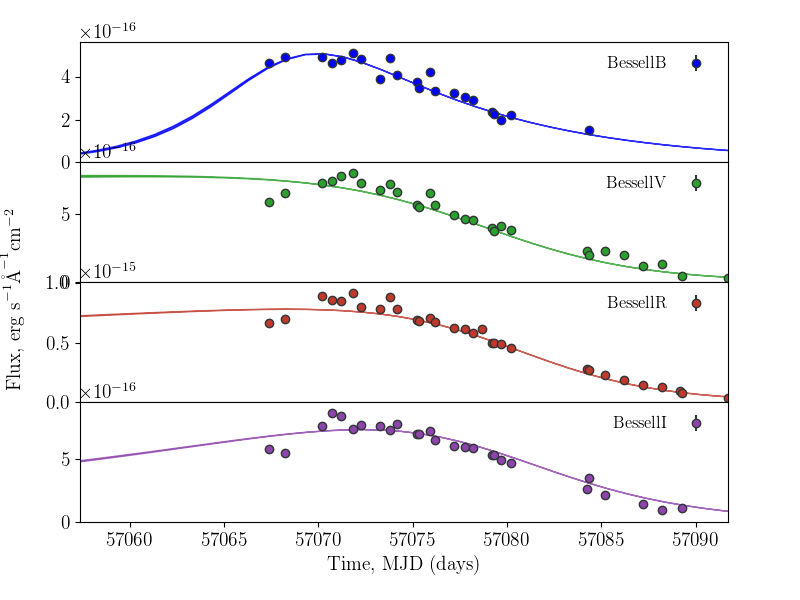

In [50]:
recon_filename = '/Users/berto/Code/CoCo/recon/SN2015U.dat'
SN.get_lcfit(recon_filename)

SN.plot_lc()

In [51]:
list_file_path = "/Users/berto/Code/CoCo/lists/"+snname+".list"
SN.load_list(path=list_file_path)

In [52]:
SN.load_spec()

<IPython.core.display.Javascript object>


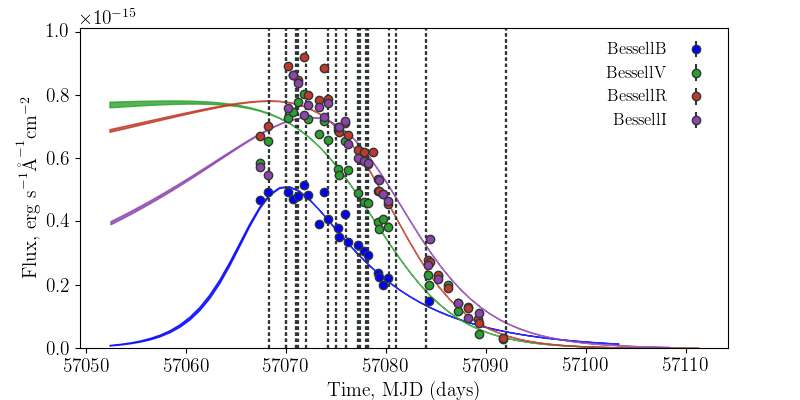

In [53]:
SN.plot_lc(multiplot=False)

In [54]:
# refit = False
refit = True

if refit:
    pcc.coco.run_LCfit(phot_outpath, model="Karpenka12")

current list.txt is up to date. re run with force = True to force.
running with Karpenka12
Running CoCo lcfit on /Users/berto/Code/CoCo/data/lc/SN2015U.dat
callargs are  ['/Users/berto/Code/CoCo/lcfit', '/Users/berto/Code/CoCo/data/lc/SN2015U.dat', '-m', 'Karpenka12']
Fit complete


/Users/berto/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


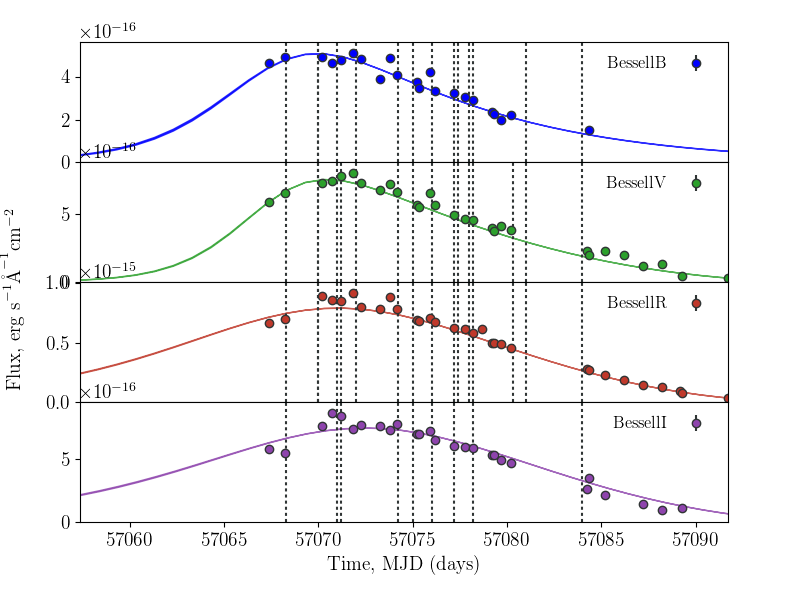

In [55]:
recon_filename = '/Users/berto/Code/CoCo/recon/SN2015U.dat'
SN.get_lcfit(recon_filename)

SN.plot_lc()

/Users/berto/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


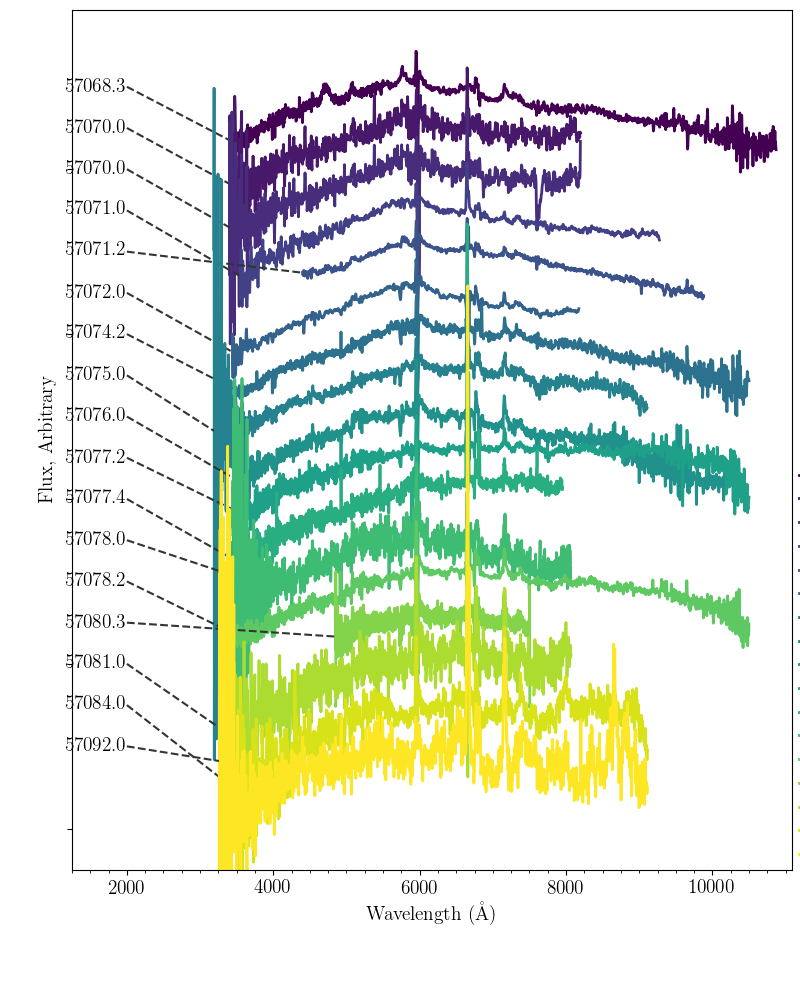

In [56]:
SN.plot_spec()

In [57]:
# plt.close("all")

In [58]:
SN.spec

OrderedDict([('psn0728+3349-20150215.256-ui.flm',
              <pycoco.classes.SpectrumClass at 0x113f0fb38>),
             ('PSNJ07285387p3349106_20150217_Ekar182_AFOSC_cal.ascii',
              <pycoco.classes.SpectrumClass at 0x113f0fc18>),
             ('SN2015U_2015-02-17_20:01:56_Asiago.ascii',
              <pycoco.classes.SpectrumClass at 0x113f24208>),
             ('PSNJ07285387p3349106_20150218_Ekar182_AFOSC_cal.ascii',
              <pycoco.classes.SpectrumClass at 0x113f24e48>),
             ('psn0728+3349-20150218.211-ir.flm',
              <pycoco.classes.SpectrumClass at 0x11424ee80>),
             ('PSNJ07285387p3349106_20150219_Ekar182_AFOSC_cal.ascii',
              <pycoco.classes.SpectrumClass at 0x11424e828>),
             ('psn0728+3349-20150221.207-ui.flm',
              <pycoco.classes.SpectrumClass at 0x11424e3c8>),
             ('PSNJ07285387p3349106_20150222_NOT_ALFOSC_cal.ascii',
              <pycoco.classes.SpectrumClass at 0x11393add8>),
             ('

# Mangle the Spectra
___

In [59]:
plot = False
wantedfilters = SN.phot.filter_names.data
anchor_distance = 1000
outfile_log = []
save = False
# save = True
for name, mS in SN.spec.items():
#     print(name, mS)
        
    S = copy.deepcopy(mS)
    fit_dict = pcc.kcorr.mangle(SN, mS, mS.mjd_obs, wantedfilters, anchor_distance=anchor_distance)
    if plot:   
        pcc.functions.plot_mangledata(S, fit_dict["data_table"], mS=fit_dict["SpectrumObject"], spl=fit_dict["final_spl"],
                        show_linear_extrap=True, normalise=True)
        
    outfile = snname+"_"+str(fit_dict["SpectrumObject"].mjd_obs).ljust(12, "0") + ".spec"
    
    
    while outfile in outfile_log:
        j=1
        outfile = snname+"_"+str(fit_dict["SpectrumObject"].mjd_obs+j*0.00001).ljust(12, "0") + ".spec"
        j+=1
    print(outfile) 
    outfile_log.append(outfile)
    
    if save:
        pcc.kcorr.save_mangle(fit_dict["SpectrumObject"], outfile, fit_dict["SpectrumObject"].infile)

 filter  fitflux spec_filterflux ... mask knot_colours   lambda_eff 
-------- ------- --------------- ... ---- ------------ -------------
BessellB     1.0             1.0 ... True      #0000ff 4354.41054934
BessellI 1.36386        0.997084 ... True      #8e44ad 8011.65864198
BessellR 1.54107          1.2988 ... True      #c0392b 6416.11806798
BessellV 1.38658         1.35636 ... True      #2ca02c  5436.8698117
SN2015U_57068.300000.spec
 filter  fitflux spec_filterflux ... mask knot_colours   lambda_eff 
-------- ------- --------------- ... ---- ------------ -------------
BessellB     1.0             1.0 ... True      #0000ff 4354.41054934
BessellR 1.53362         1.53606 ... True      #c0392b 6416.11806798
BessellV 1.46446         1.51364 ... True      #2ca02c  5436.8698117
SN2015U_57070.000000.spec
 filter  fitflux spec_filterflux ... mask knot_colours   lambda_eff 
-------- ------- --------------- ... ---- ------------ -------------
BessellB     1.0             1.0 ... True      #000

In [60]:
# run_specfit = True
run_specfit = False
if run_specfit:
    pcc.coco.run_specfit(SN, save=False, plot = True)

# **`CoCo specphase`**
---


In [61]:
# run = True
run = False
if run:
    phase_path = os.path.join(pcc.defaults._default_coco_dir_path, "examples/phase.list")
    pcc.coco.run_specphase("BessellV", phase_path)

In [62]:
snname = "SN2015U"
spectra_dir="spectra/"
coco_dir=pcc.defaults._default_coco_dir_path
absolute_path=False
spectra_dir = os.path.join(coco_dir, spectra_dir)

pcc.utils.check_dir_path(spectra_dir)

dir_list = [spec for spec in os.listdir(spectra_dir) if spec[:len(snname)] == snname]

dir_list

if True:
    print(len(dir_list), "files found matching", snname)
    print(dir_list)

18 files found matching SN2015U
['SN2015U_57068.300000.spec', 'SN2015U_57068.300010.spec', 'SN2015U_57070.000000.spec', 'SN2015U_57070.000010.spec', 'SN2015U_57071.000000.spec', 'SN2015U_57071.200000.spec', 'SN2015U_57072.000000.spec', 'SN2015U_57074.200000.spec', 'SN2015U_57075.000000.spec', 'SN2015U_57076.000000.spec', 'SN2015U_57077.200000.spec', 'SN2015U_57077.400000.spec', 'SN2015U_57078.000000.spec', 'SN2015U_57078.200000.spec', 'SN2015U_57080.300000.spec', 'SN2015U_57081.000000.spec', 'SN2015U_57084.000000.spec', 'SN2015U_57092.000000.spec']


In [63]:
pcc.coco.check_specphase(snname)

['SN2015U_57068.300000.spec',
 'SN2015U_57068.300010.spec',
 'SN2015U_57070.000000.spec',
 'SN2015U_57070.000010.spec',
 'SN2015U_57071.000000.spec',
 'SN2015U_57071.200000.spec',
 'SN2015U_57072.000000.spec',
 'SN2015U_57074.200000.spec',
 'SN2015U_57075.000000.spec',
 'SN2015U_57076.000000.spec',
 'SN2015U_57077.200000.spec',
 'SN2015U_57077.400000.spec',
 'SN2015U_57078.000000.spec',
 'SN2015U_57078.200000.spec',
 'SN2015U_57080.300000.spec',
 'SN2015U_57081.000000.spec',
 'SN2015U_57084.000000.spec',
 'SN2015U_57092.000000.spec']

# Simulate

In [64]:
from lcsim.lcsim import LCSim
import pyCoCo as pccsim

fltPath = pcc.utils.b(pcc.defaults._default_filter_dir_path)
rootPath = pcc.utils.b(pcc.defaults._default_coco_dir_path)
coco = pccsim.pyCoCo(fltPath, rootPath)
lcs = LCSim()

info = pcc.classes.InfoClass()
info.load(path=pcc.defaults._default_info_path.replace(".dat", "_new.dat"))

print(fltPath, rootPath)

b'/Users/berto/Code/CoCo/data/filters/' b'/Users/berto/Code/CoCo/'


/Users/berto/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


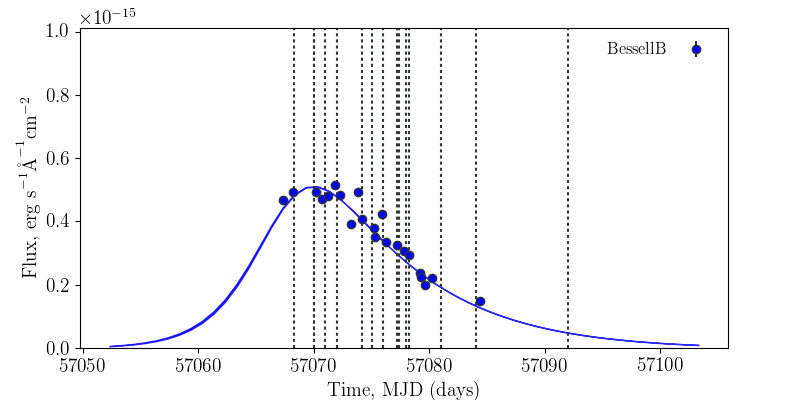

In [65]:
SN.plot_lc(multiplot=False, filters=["BessellB"])

In [66]:
mjdmax = pcc.utils.get_mjdmax(SN, "BessellB")[0]
mjdmax_to_sim = 0
z_to_sim = info.get_sn_info(SN.name)["z_distmod"][0]

print("MJDMAX = ", mjdmax)
print("SIM z = ", z_to_sim)

MJDMAX =  57069.927
SIM z =  0.0139105095863


In [67]:
path_to_filter = os.path.join(pcc.defaults._default_filter_dir_path,"BessellB.dat")  

BessellB = pcc.classes.FilterClass()
BessellB.read_filter_file(path_to_filter)
BessellB.calculate_AB_zp()

mjd_list = np.arange(0.,95,0.1)-30.
mjd_to_sim = np.array([])
filters_to_sim = []

for mjd in mjd_list:
    filters_to_sim = np.append(filters_to_sim, pcc.utils.b(BessellB.filter_name))
    mjd_to_sim = np.append(mjd_to_sim, mjd)

time_dilation = 1.+z_to_sim

def time_dilate(mjd_arr, z, mjdmax=False):
    if mjdmax:
        mjd_arr = mjd_arr - mjdmax
    
    return mjd_arr * (1.0 + z_to_sim)
    

In [68]:
flux, flux_err = coco.simulate(pcc.utils.b(SN.name),
                               z_to_sim, 0.0, 0.0, 0.0, 3.1,
                               mjdmax_to_sim, mjd_to_sim,
                               filters_to_sim)

specphot = coco.spec_photometry(pcc.utils.b(SN.name), 
             z_to_sim, b"BessellB")


In [69]:
sn_sim = pcc.classes.SNClass("SN2015U")
sn_sim.load_phot(phot_table = pcc.utils.simulate_out_to_ap_table(mjd_to_sim, flux, flux_err, filters_to_sim))
sn_sim.phot.phot["m_AB"] = -2.5 * np.log10(sn_sim.phot.phot["flux"]) - BessellB.zp_AB

sp = pcc.classes.PhotometryClass()
sp.load_table(pcc.utils.specphot_out_to_ap_table(specphot, mjdmax_to_sim, "BessellB"))
sp.phot["m_AB"] = -2.5 * np.log10(sp.phot["flux"]) - BessellB.zp_AB

/Users/berto/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


/Users/berto/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


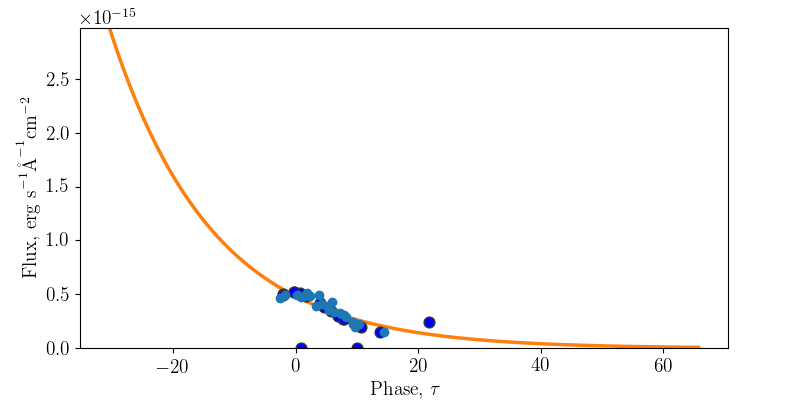

In [70]:
yaxis_lim_multiplier=1.1
verbose=False
lw=2.5
markersize=60.0
xminorticks=5.
yminorticks=0.5

pcc.utils.setup_plot_defaults()

fig = plt.figure(figsize=[8, 4])

fig.subplots_adjust(left = 0.1, bottom = 0.13, top = 0.93,
                    right = 0.91, hspace=0, wspace = 0)
ax1 = fig.add_subplot(111)
xaxis_label_string = r"$\textnormal{Phase, }\tau$"
yaxis_label_string = r'$\textnormal{Flux, erg s}^{-1}\textnormal{\AA}^{-1}\textnormal{cm}^{-2}$'


ax1.scatter(sp.phot["MJD"]*time_dilation, sp.phot["flux"], color = pcc.colours.hex["BessellB"], 
            label = r"$\textnormal{Bessell B}$", edgecolors = pcc.colours.hex["batman"], 
            s=markersize)
ax1.plot(mjd_to_sim*time_dilation, flux, color = "C1", label = r"$"+str(round(z_to_sim, 4))+"$",
         lw=lw, zorder=0)
ax1.errorbar(SN.phot.data["BessellB"]["MJD"]-mjdmax, SN.phot.data["BessellB"]["flux"], yerr=SN.phot.data["BessellB"]["flux_err"], fmt="o")

ax1.set_ylim(0, np.nanmax(np.append(sp.phot["flux"].data, flux)))
ax1.set_xlabel(xaxis_label_string)
ax1.set_ylabel(yaxis_label_string)

/Users/berto/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


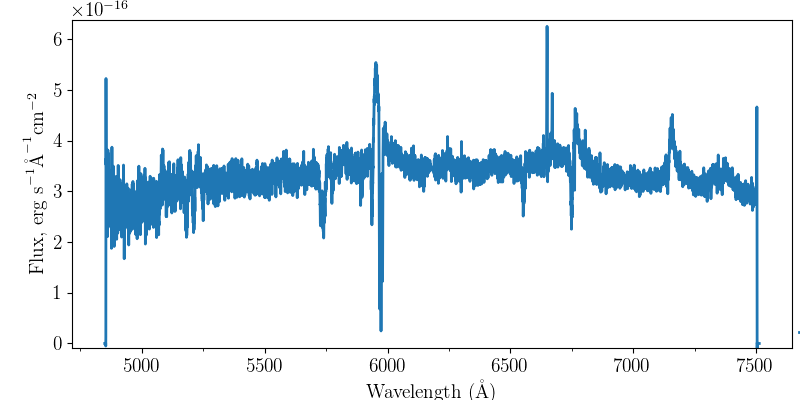

In [71]:
SN.spec["psn0728+3349-20150227.34.deimos.flm"].plot()

In [72]:
sp.phot["flux"].data

array([  1.51837878e-16,   2.40110302e-16,   5.07359727e-16,
         2.72190483e-16,   0.00000000e+00,   3.44430897e-16,
         1.91653786e-16,   2.92632570e-16,   4.97773396e-16,
         3.83390594e-16,   3.00163201e-16,   4.86803290e-16,
         0.00000000e+00,   2.65512084e-16,   5.15858874e-16,
         5.15871149e-16,   4.14134076e-16,   4.96894356e-16])